<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek41.do.txt  -->
<!-- dom:TITLE: Exercises week 41 -->

# Exercises week 41
**October 4-11, 2024**

Date: **Deadline is Friday October 11 at midnight**

# Overarching aims of the exercises this week

The aim of the exercises this week is to get started with implementing
gradient methods of relevance for project 2. This exercise will also
be continued next week with the addition of automatic differentation.
Everything you develop here will be used in project 2.

In order to get started, we will now replace in our standard ordinary
least squares (OLS) and Ridge regression codes (from project 1) the
matrix inversion algorithm with our own gradient descent (GD) and SGD
codes.  You can use the Franke function or the terrain data from
project 1. **However, we recommend using a simpler function like**
$f(x)=a_0+a_1x+a_2x^2$ or higher-order one-dimensional polynomials.
You can obviously test your final codes against for example the Franke
function. Automatic differentiation will be discussed next week.

You should include in your analysis of the GD and SGD codes the following elements
1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression of the gradients

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate), again using the analytical expression of the gradients.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

The lecture notes from weeks 39 and 40 contain more information and code examples. Feel free to use these examples.

In summary, you should 
perform an analysis of the results for OLS and Ridge regression as
function of the chosen learning rates, the number of mini-batches and
epochs as well as algorithm for scaling the learning rate. You can
also compare your own results with those that can be obtained using
for example **Scikit-Learn**'s various SGD options.  Discuss your
results. For Ridge regression you need now to study the results as functions of  the hyper-parameter $\lambda$ and 
the learning rate $\eta$.  Discuss your results.

You will need your SGD code for the setup of the Neural Network and
Logistic Regression codes. You will find the Python [Seaborn
package](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
useful when plotting the results as function of the learning rate
$\eta$ and the hyper-parameter $\lambda$ when you use Ridge
regression.

We recommend reading chapter 8 on optimization from the textbook of [Goodfellow, Bengio and Courville](https://www.deeplearningbook.org/). This chapter contains many useful insights and discussions on the optimization part of machine learning.

In [1]:
# Linear algebra and numerical operations
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

# Random number generation
from random import random, seed

# Warnings
import warnings
warnings.filterwarnings("ignore")

import autograd.numpy as np
from autograd import grad

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data-y_model)**2)/n

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)
    
	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))
    
	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)
    
	return X

def mse_and_r2_sk(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    return mse, r2

In [3]:
n = 100
max_degree = 15
x = np.random.rand(n)
y = np.random.rand(n)
x = np.sort(x)
y = np.sort(y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y) + 0.1*np.random.normal(0,1, x.shape)

x = x.reshape(-1,1) # reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

X = create_X(x, y, max_degree) # creating the design matrix

### OLS

In [4]:
# ------------------------ Gradient Descent ------------------------
def gradient_descent(X, y, number_iter = 1000):
    H = (2.0/n)* X.T @ X #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    for iter in range(number_iter):
        gradients = 2.0/n * X.T @ ((X @ theta) - y)
        theta -= np.real(eta) * gradients
    return theta


def gradient_descent_momentum(X, y, number_iter = 1000, change = 0.0, delta_momentum = 0.3):
    H = (2.0/n)* X.T @ X #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    for iter in range(number_iter):
        gradients = 2.0/n * X.T @ ((X @ theta) - y)
        new_change = np.real(eta) * gradients + delta_momentum * change
        theta -= new_change
        change = new_change
    return theta


# ------------------------ Stochastic Gradient Descent ------------------------
def learning_schedule(t, t_0, t_1):
    return t_0/(t + t_1)


def stochastic_gradient_descent(X, y, number_epochs = 50, M = 5, t_0 = 5, t_1 = 50):    
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (2.0/M)* x_i.T @ ((x_i @ theta) - y_i)
            eta = learning_schedule(epoch * m + i, t_0, t_1)
            theta -= eta * gradients
    return theta


def stochastic_gradient_descent_momentum(X, y, number_epochs = 50, M = 5, t_0 = 5, t_1 = 50, change = 0.0, delta_momentum = 0.3):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (2.0/M)* x_i.T @ ((x_i @ theta) - y_i)
            eta = learning_schedule(epoch * m + i, t_0, t_1)
            new_change = np.real(eta) * gradients + delta_momentum * change
            theta -= new_change
            change = new_change
    return theta

# ------------------------ Adagram ------------------------
def CostOLS(X, y, beta):
    return (1.0/n)*np.sum((y - X @ beta)**2)


def Adagrad_GD(X, y, number_iter = 1000, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    H = (2.0/n)* X.T @ X #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    Giter = 0.0
    for iter in range(number_iter):
        gradients = 2.0/n* X.T @ ((X @ theta) - y)
        Giter += gradients*gradients
        update = np.real(eta) * gradients/(delta + np.sqrt(Giter))
        if momentum == False:
            theta -= update
        else:
            new_change = update + delta_momentum * change
            theta -= new_change
            change = new_change
    return theta


def Adagrad_SGD(X, y, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    training_gradient = grad(CostOLS, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        Giter = 0.0
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta)
            Giter += gradients*gradients
            update = gradients*eta/ (delta + np.sqrt(Giter))
            if momentum == False:
                theta -= update
            else:
                new_change = update + delta_momentum * change
                theta -= new_change
                change = new_change
    return theta

# ------------------------ RMSprop and ADAM ------------------------
def RMSprop(X, y, number_epochs = 50, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8):
    training_gradient = grad(CostOLS, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(number_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index + M]
            y_i = y[rand_index:rand_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta)
            Giter = (rho*Giter + (1-rho)*gradients*gradients)
            update = gradients*eta/(delta + np.sqrt(Giter))
            theta -= update
    return theta


def ADAM(X, y, number_epochs = 50, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-8):
    training_gradient = grad(CostOLS, 2)
    m = int(n/M) #number of minibatches
    theta = np.random.randn(X.shape[1], 1)
    
    iter = 0
    for epoch in range(number_epochs):
        first_moment = 0.0
        second_moment = 0.0
        iter += 1
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta)
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment+(1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            update = eta*first_term/(np.sqrt(second_term)+delta)
            theta -= update
    return theta

In [5]:
def degree_gradient(x, y, z, max_degree, methods, method):
    MSE_train_values = np.zeros(max_degree)
    MSE_test_values = np.zeros(max_degree)
    
    for degree in range(1, max_degree + 1):
        X = create_X(x, y, degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, random_state = 42)
        theta = methods[method](X_train, z_train)
        # ---------------------- OLS ----------------------
        z_train_pred_ols = X_train @ theta
        z_test_pred_ols = X_test @ theta
        
        MSE_train_values[degree - 1] = MSE(z_train, z_train_pred_ols)
        MSE_test_values[degree - 1] = MSE(z_test, z_test_pred_ols)
        # R2_train_ols[degree - 1] = r2_score(z_train, z_train_pred_ols)
        # R2_test_ols[degree - 1] = r2_score(z_test, z_test_pred_ols)
    # return MSE_train_values, MSE_test_values, MSE_train_values_sk, MSE_test_values_sk
    return MSE_train_values, MSE_test_values

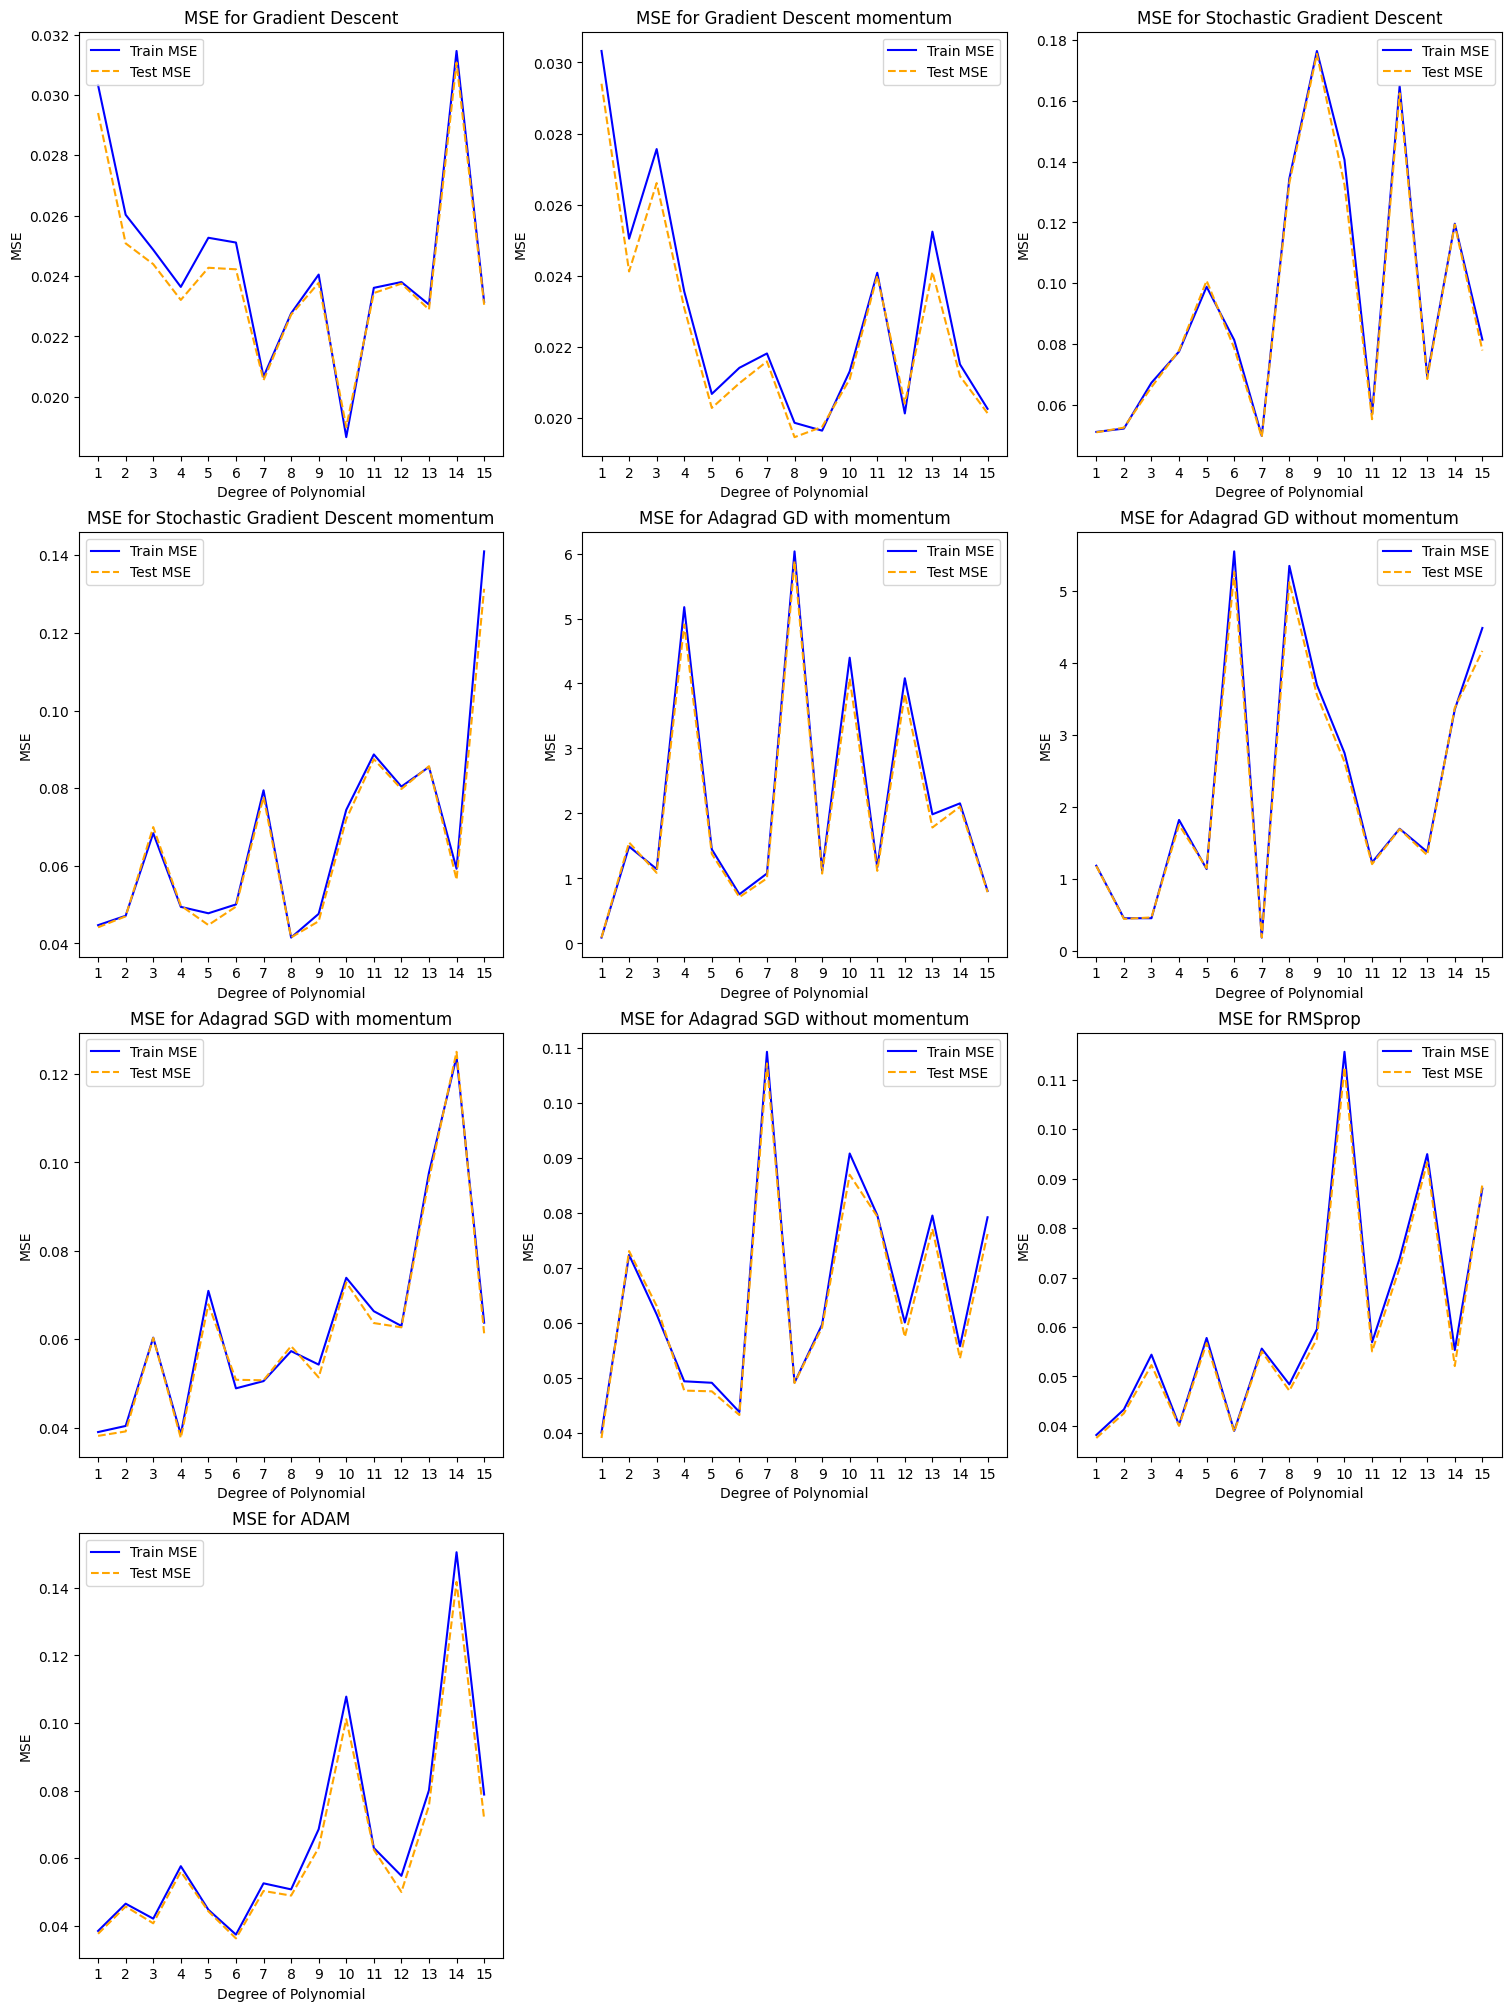

In [6]:
methods = {
    'Gradient Descent': lambda X, z: gradient_descent(X, z, number_iter=1000),
    'Gradient Descent momentum': lambda X, z: gradient_descent_momentum(X, z, number_iter=1000, change=0.0, delta_momentum=0.3),
    'Stochastic Gradient Descent': lambda X, z: stochastic_gradient_descent(X, z, number_epochs=100, M=5, t_0=5, t_1=50),
    'Stochastic Gradient Descent momentum': lambda X, z: stochastic_gradient_descent_momentum(X, z, number_epochs=100, M=5, t_0=5, t_1=50, change=0.0, delta_momentum=0.3),
    'Adagrad GD with momentum': lambda X, z: Adagrad_GD(X, z, number_iter = 50, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True),
    'Adagrad GD without momentum': lambda X, z: Adagrad_GD(X, z, number_iter = 50, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False),
    'Adagrad SGD with momentum': lambda X, z: Adagrad_SGD(X, z, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True),
    'Adagrad SGD without momentum': lambda X, z: Adagrad_SGD(X, z, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False),
    'RMSprop': lambda X, z: RMSprop(X, z, number_epochs = 50, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8),
    'ADAM': lambda X, z: ADAM(X, z, number_epochs = 50, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-8)
}

n_methods = len(methods.keys())
n_cols = 3
n_rows = int(np.ceil(n_methods / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axs = axs.flatten()

for idx, method in enumerate(methods.keys()):
    MSE_train_values, MSE_test_values = degree_gradient(x, y, z, max_degree, methods, method)

    axs[idx].plot(range(1, max_degree + 1), MSE_train_values, label='Train MSE', color='blue')
    axs[idx].plot(range(1, max_degree + 1), MSE_test_values, label='Test MSE', linestyle='--', color='orange')
    axs[idx].set_xlabel('Degree of Polynomial')
    axs[idx].set_xticks(ticks=range(1, max_degree + 1))
    axs[idx].set_ylabel('MSE')
    axs[idx].set_title(f'MSE for {method}')
    axs[idx].legend()

for i in range(idx + 1, len(axs)):
    fig.delaxes(axs[i])
plt.show()

**Gradient Descent vs SGD**: In general, gradient descent methods (with and without momentum) seem to handle simpler polynomial degrees better, while SGD introduces more noise and fluctuation due to its stochastic nature.

**Momentum**: Across all methods, momentum consistently helps to stabilize learning, leading to smoother convergence and reducing oscillations in MSE, particularly in higher-degree polynomials.

**Adagrad and RMSprop**: Adaptive learning rate methods like Adagrad and RMSprop show mixed results. While they dynamically adjust learning rates to improve convergence, they still struggle with higher-degree polynomials, especially when not combined with momentum.

**Adam**: Adam provides the best balance overall, benefiting from both momentum and adaptive learning rates, which leads to stable results across a range of complexities.
In summary, the choice of optimization method significantly impacts performance, especially as the complexity of the model increases. For simpler problems, plain gradient descent or SGD may suffice, but for more complex problems, methods like Adam or RMSprop with momentum generally perform better, offering more stability and faster convergence.

### Ridge

In [7]:
# ------------------------ Gradient Descent ------------------------
def gradient_descent_Ridge(X, y, best_lambda, number_iter = 1000):
    I = np.eye(X.shape[1])
    H = (2.0/n)* X.T @ X + 2.0 * best_lambda * I  #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    for iter in range(number_iter):
        gradients = 2.0/n * X.T @ ((X @ theta) - y) + 2.0 * best_lambda * theta
        theta -= np.real(eta) * gradients
    return theta


def gradient_descent_momentum_Ridge(X, y, best_lambda, number_iter = 1000, change = 0.0, delta_momentum = 0.3):
    I = np.eye(X.shape[1])
    H = (2.0/n)* X.T @ X + 2.0 * best_lambda * I  #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    for iter in range(number_iter):
        gradients = 2.0/n * X.T @ ((X @ theta) - y) + 2.0 * best_lambda * theta
        new_change = np.real(eta) * gradients + delta_momentum * change
        theta -= new_change
        change = new_change
    return theta

# ------------------------ Stochastic Gradient Descent ------------------------
def learning_schedule_Ridge(t, t_0, t_1):
    return t_0/(t + t_1)


def stochastic_gradient_descent_Ridge(X, y, best_lambda, number_epochs = 50, M = 5, t_0 = 5, t_1 = 50):    
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (2.0/M)* x_i.T @ ((x_i @ theta) - y_i) + 2.0 * best_lambda * theta
            eta = learning_schedule_Ridge(epoch * m + i, t_0, t_1)
            theta -= eta * gradients
    return theta


def stochastic_gradient_descent_momentum_Ridge(X, y, best_lambda, number_epochs = 50, M = 5, t_0 = 5, t_1 = 50, change = 0.0, delta_momentum = 0.3):
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (2.0/M)* x_i.T @ ((x_i @ theta) - y_i) + 2.0 * best_lambda * theta
            eta = learning_schedule(epoch * m + i, t_0, t_1)
            new_change = np.real(eta) * gradients + delta_momentum * change
            theta -= new_change
            change = new_change
    return theta

# ------------------------ Adagram ------------------------
def CostOLS_Ridge(X, y, beta):
    return (1.0/n)*np.sum((y - X @ beta)**2)


def Adagrad_GD_Ridge(X, y, best_lambda, number_iter = 1000, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    I = np.eye(X.shape[1])
    H = (2.0/n)* X.T @ X + 2.0 * best_lambda * I  #Hessian matrix
    EigValues, EigVectors = np.linalg.eig(H)
    theta = np.random.randn(X.shape[1], 1)
    eta = 1.0/np.max(EigValues)
    
    Giter = 0.0
    for iter in range(number_iter):
        gradients = 2.0/n* X.T @ ((X @ theta) - y) + 2.0 * best_lambda * theta
        Giter += gradients*gradients
        update = np.real(eta) * gradients/(delta + np.sqrt(Giter))
        if momentum == False:
            theta -= update
        else:
            new_change = update + delta_momentum * change
            theta -= new_change
            change = new_change
    return theta


def Adagrad_SGD_Ridge(X, y, best_lambda, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False):
    training_gradient = grad(CostOLS_Ridge, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    
    for epoch in range(number_epochs):
        Giter = 0.0
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta) 
            Giter += gradients*gradients
            update = gradients*eta/ (delta + np.sqrt(Giter))
            if momentum == False:
                theta -= update
            else:
                new_change = update + delta_momentum * change
                theta -= new_change
                change = new_change
    return theta

# ------------------------ RMSprop and ADAM ------------------------
def RMSprop_Ridge(X, y, best_lambda, number_epochs = 50, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8):
    training_gradient = grad(CostOLS_Ridge, 2)
    theta = np.random.randn(X.shape[1], 1)
    m = int(n/M)
    for epoch in range(number_epochs):
        Giter = 0.0
        for i in range(m):
            rand_index = M + np.random.randint(m)
            x_i = X[rand_index:rand_index + M]
            y_i = y[rand_index:rand_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta)
            Giter = (rho*Giter + (1-rho)*gradients*gradients)
            update = gradients*eta/(delta + np.sqrt(Giter))
            theta -= update
    return theta


def ADAM_Ridge(X, y, best_lambda, number_epochs = 50, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-8):
    training_gradient = grad(CostOLS_Ridge, 2)
    m = int(n/M) #number of minibatches
    theta = np.random.randn(X.shape[1], 1)
    
    iter = 0
    for epoch in range(number_epochs):
        first_moment = 0.0
        second_moment = 0.0
        iter += 1
        for i in range(m):
            random_index = M + np.random.randint(m)
            x_i = X[random_index:random_index + M]
            y_i = y[random_index:random_index + M]
            gradients = (1.0/M)*training_gradient(x_i, y_i, theta)
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment+(1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            update = eta*first_term/(np.sqrt(second_term)+delta)
            theta -= update
    return theta

In [8]:
# Function to determine the best lambdas with Ridge Regression

def best_lambdas_Ridge(X_train_val, z_train_val, lambdas):
    X_train, X_validation, z_train, z_validation = train_test_split(X_train_val, z_train_val, test_size=0.1, random_state=10)
    MSE_train_Ridge = []
    MSE_test_Ridge = []
    R2_train_Ridge = []
    R2_test_Ridge = []
    
    for l in range(len(lambdas)):
        model_Ridge = Ridge(lambdas[l], fit_intercept=False)
        model_Ridge.fit(X_train, z_train)
        z_train_pred_Ridge = model_Ridge.predict(X_train)
        z_test_pred_Ridge = model_Ridge.predict(X_validation)
        
        mse_train, r2_train = mse_and_r2_sk(z_train, z_train_pred_Ridge)
        mse_validation, r2_validation = mse_and_r2_sk(z_validation, z_test_pred_Ridge)
        
        MSE_train_Ridge.append(mse_train)
        MSE_test_Ridge.append(mse_validation)
        R2_train_Ridge.append(r2_train)
        R2_test_Ridge.append(r2_validation)
    
    best_index = np.argmin(MSE_test_Ridge)
    best_alpha_Ridge = lambdas[best_index]
    return best_alpha_Ridge

In [9]:
def degree_gradient_Ridge(x, y, z, max_degree, methods, method):
    MSE_train_values = np.zeros(max_degree)
    MSE_test_values = np.zeros(max_degree)
    
    lambdas = np.logspace(-5, 5, 20)
    for degree in range(1, max_degree + 1):
        X = create_X(x, y, degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, random_state = 42)
        best_alpha_Ridge = best_lambdas_Ridge(X_train, z_train, lambdas)
        theta = methods[method](X_train, z_train, best_alpha_Ridge)
        # ---------------------- Ridge ----------------------
        z_train_pred_ols = X_train @ theta
        z_test_pred_ols = X_test @ theta
        
        MSE_train_values[degree - 1] = MSE(z_train, z_train_pred_ols)
        MSE_test_values[degree - 1] = MSE(z_test, z_test_pred_ols)
    return MSE_train_values, MSE_test_values

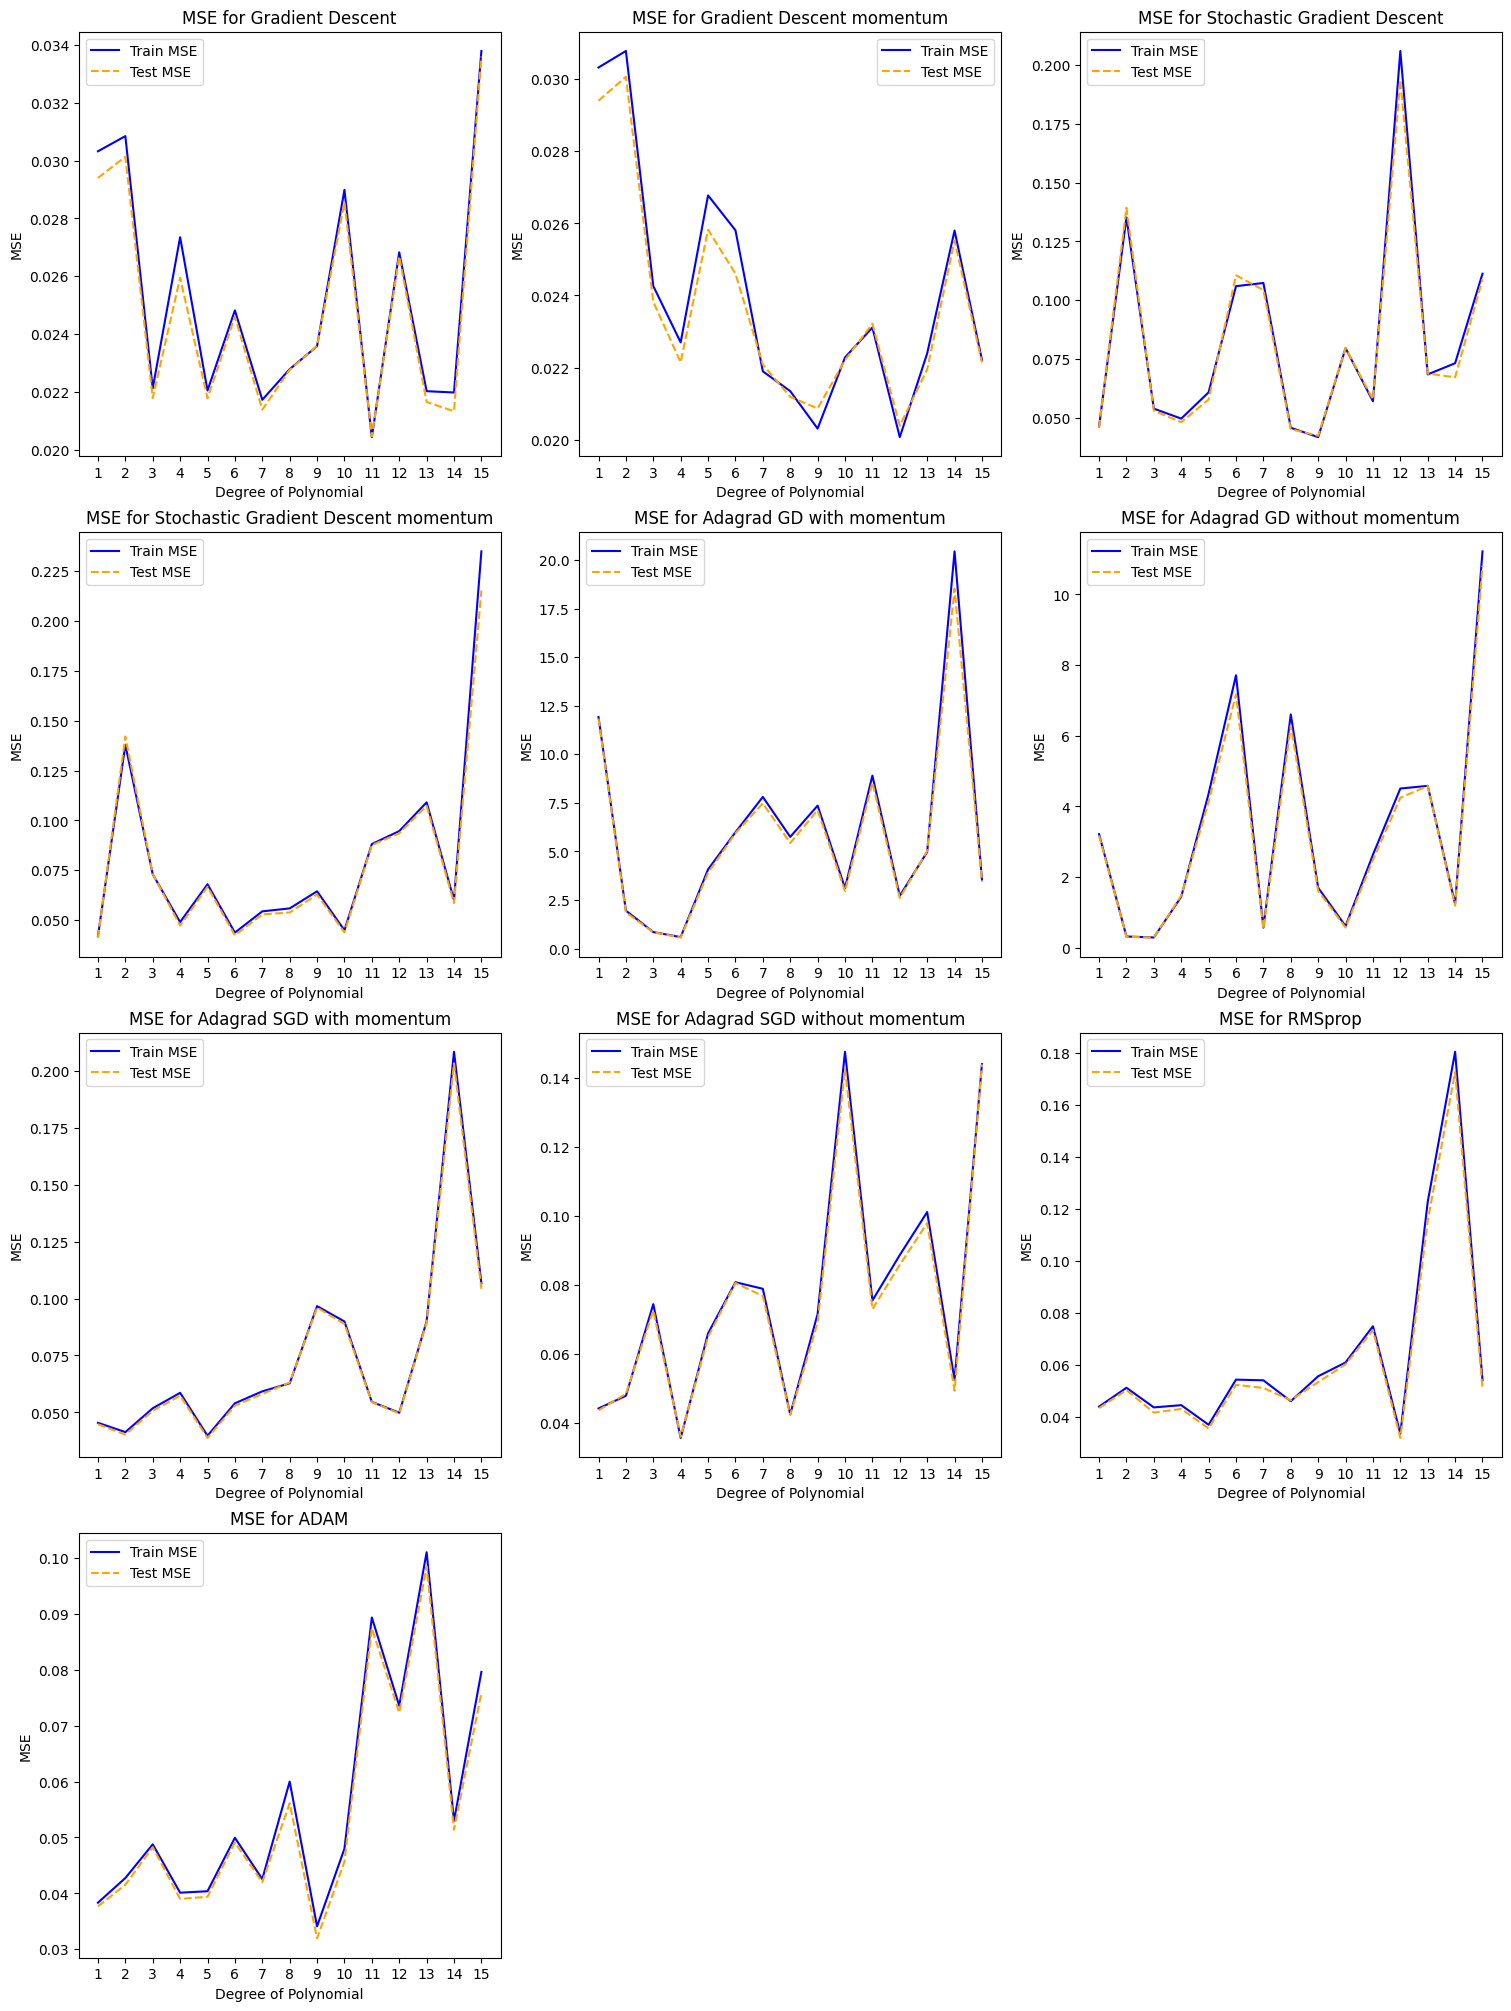

In [10]:
methods = {
    'Gradient Descent': lambda X, z, alpha: gradient_descent_Ridge(X, z, alpha, number_iter=1000),
    'Gradient Descent momentum': lambda X, z, alpha: gradient_descent_momentum_Ridge(X, z, alpha, number_iter=1000, change=0.0, delta_momentum=0.3),
    'Stochastic Gradient Descent': lambda X, z, alpha: stochastic_gradient_descent_Ridge(X, z, alpha, number_epochs=100, M=5, t_0=5, t_1=50),
    'Stochastic Gradient Descent momentum': lambda X, z, alpha: stochastic_gradient_descent_momentum_Ridge(X, z, alpha, number_epochs=100, M=5, t_0=5, t_1=50, change=0.0, delta_momentum=0.3),
    'Adagrad GD with momentum': lambda X, z, alpha: Adagrad_GD_Ridge(X, z, alpha, number_iter = 50, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True),
    'Adagrad GD without momentum': lambda X, z, alpha: Adagrad_GD_Ridge(X, z, alpha, number_iter = 50, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False),
    'Adagrad SGD with momentum': lambda X, z, alpha: Adagrad_SGD_Ridge(X, z, alpha, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = True),
    'Adagrad SGD without momentum': lambda X, z, alpha: Adagrad_SGD_Ridge(X, z, alpha, number_epochs = 50, M = 5, eta = 0.01, delta = 1e-8, change = 0.0, delta_momentum = 0.3, momentum = False),
    'RMSprop': lambda X, z, alpha: RMSprop_Ridge(X, z, alpha, number_epochs = 50, M = 5, eta = 0.01, rho = 0.90, delta = 1e-8),
    'ADAM': lambda X, z, alpha: ADAM_Ridge(X, z, alpha, number_epochs = 50, M = 5, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-8)
}

n_methods = len(methods.keys())
n_cols = 3
n_rows = int(np.ceil(n_methods / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axs = axs.flatten()

for idx, method in enumerate(methods.keys()):
    MSE_train_values, MSE_test_values = degree_gradient_Ridge(x, y, z, max_degree, methods, method)

    axs[idx].plot(range(1, max_degree + 1), MSE_train_values, label='Train MSE', color='blue')
    axs[idx].plot(range(1, max_degree + 1), MSE_test_values, label='Test MSE', linestyle='--', color='orange')
    axs[idx].set_xlabel('Degree of Polynomial')
    axs[idx].set_xticks(ticks=range(1, max_degree + 1))
    axs[idx].set_ylabel('MSE')
    axs[idx].set_title(f'MSE for {method}')
    axs[idx].legend()

for i in range(idx + 1, len(axs)):
    fig.delaxes(axs[i])
plt.show()

## Franke Function Plot

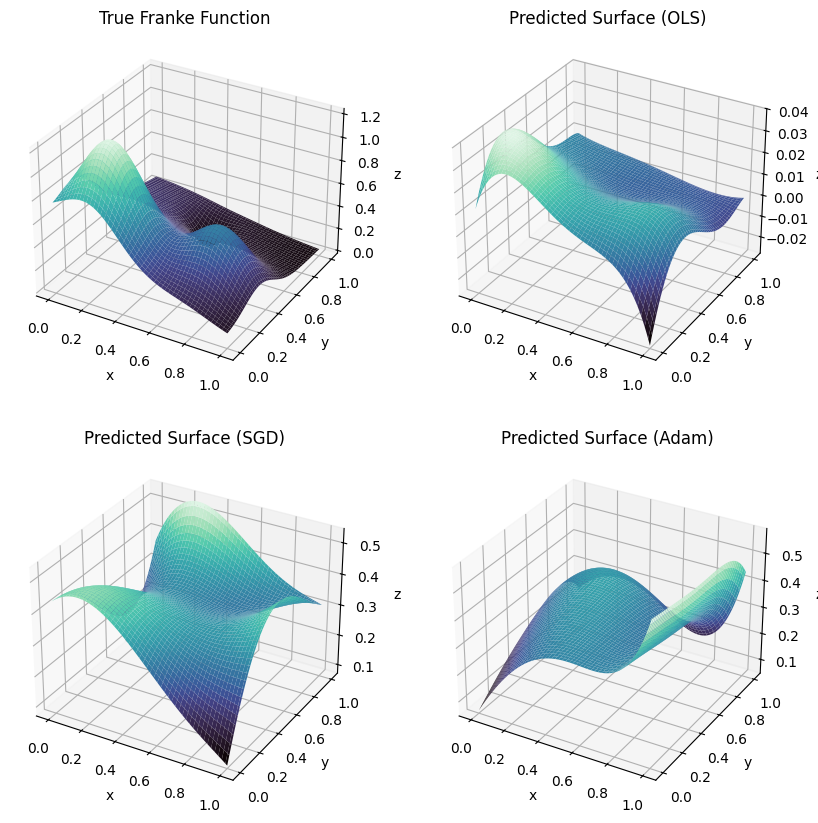

In [11]:
np.random.seed(2745)
n = 100                                      # Number of points
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.1 * np.random.normal(0, 1, n)

# Define function to create the design matrix
def design_matrix(x, y, degree):
    N = len(x)
    l = int((degree + 1) * (degree + 2) / 2)  # Number of terms in polynomial
    X = np.ones((N, l))  # Start with ones matrix
    idx = 1
    for i in range(1, degree + 1):
        for j in range(i + 1):
            X[:, idx] = (x**(i-j)) * (y**j)
            idx += 1
    return X

# Create design matrix for fifth-degree polynomial
degree = 5
X_manual = design_matrix(x, y, degree)
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
X_grid = create_X(x_flat, y_flat, degree)

# Predicted values
# ---------------------- OLS ----------------------
X_manual = create_X(x, y, degree)
theta_ols = np.linalg.inv(X_manual.T @ X_manual) @ X_manual.T @ z
theta_ols = (theta_ols - np.mean(theta_ols)) / np.std(theta_ols)

z_pred_ols = X_grid @ theta_ols
z_pred_ols = z_pred_ols.reshape(x_mesh.shape)

# ---------------------- Adagrad Stochastic gradient descent ----------------------
theta_sgd = Adagrad_SGD(X_manual, z, number_epochs = 100, M = 10, eta = 0.01, delta = 1e-7, change = 0.0, delta_momentum = 0.3, momentum = False)
z_pred_sgd = X_grid @ theta_sgd
z_pred_sgd = z_pred_sgd.reshape(x_mesh.shape)

# ---------------------- Adam ----------------------
theta_adam = ADAM(X_manual, z, number_epochs = 100, M = 10, eta = 0.01, beta1 = 0.9, beta2 = 0.999, delta = 1e-7)
z_pred_Adm = X_grid @ theta_adam
z_pred_Adm = z_pred_Adm.reshape(x_mesh.shape)

z_true = FrankeFunction(x_mesh, y_mesh)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x_mesh, y_mesh, z_true, cmap='mako')
ax1.set_title('True Franke Function')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x_mesh, y_mesh, z_pred_ols, cmap='mako')
ax2.set_title('Predicted Surface (OLS)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

ax2 = fig.add_subplot(223, projection='3d')
ax2.plot_surface(x_mesh, y_mesh, z_pred_sgd, cmap='mako')
ax2.set_title('Predicted Surface (SGD)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

ax2 = fig.add_subplot(224, projection='3d')
ax2.plot_surface(x_mesh, y_mesh, z_pred_Adm, cmap='mako')
ax2.set_title('Predicted Surface (Adam)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.show()